In [1]:
import os
import numpy as np
import h5py
from scipy import stats
import scipy.io
import mne
from random import shuffle
import random
from copy import deepcopy

mne.set_log_level('error')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold




from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors


import torch
import torch.nn as nn
import torch.optim as optim

import optuna


from utils.load import Load
from config.default import cfg

%load_ext autoreload
%autoreload 2


##### Load EEG data in MNE format to access electrode position

In [2]:
subject_id = 1


In [3]:
loader = Load(cfg)
demo = loader.load_subject(subject_id = subject_id)[0]

#### Training

In [4]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(device)

cuda


In [5]:
# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's built-in random number generator
random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Load the dictionary from the HDF5 file
target_dir = 'features'
tag = '0_25powers'

file_path = os.path.join(target_dir, tag+'_'+cfg['subjects'][subject_id] + '.h5')


data = {}
with h5py.File(file_path, 'r') as h5file:
    for key in h5file.keys():
        data[key] = np.array(h5file[key])

# Print the loaded data dictionary
for key, value in data.items():
    #data[key] = np.reshape(value, (value.shape[0], -1))
    print(key, data[key].shape)

index (50, 158, 30, 2)
little (50, 158, 30, 2)
middle (50, 158, 30, 2)
ring (50, 158, 30, 2)
thumb (50, 158, 30, 2)


In [7]:
class SingleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        x = x.view(x.size(0), -1)
 
        x = self.fc1(x)
      
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [8]:


def train_sequence(finger1, finger2):
    
    learning_rate = 0.0028774322222191256
    num_epochs= 1860
    hidden_size =47
    activation =nn.ReLU()
    optimizer = optim.SGD


    X = np.concatenate((data[finger1], data[finger2]), axis=0)
    y = np.concatenate((np.ones(data[finger1].shape[0]), np.zeros(data[finger2].shape[0])), axis=0)


    def train(X_train, y_train, X_test, y_test, model, criterion, optimizer, num_epochs=100):
        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)
        y_test = torch.tensor(y_test, dtype=torch.long).to(device)


        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            y_pred = model(X_test)
            y_pred = torch.argmax(y_pred, dim=1)

        acc = accuracy_score(y_test.cpu(), y_pred.cpu())
        
        return acc



    # bests = [1,  ]
    # print(X.shape)
    # X = X[:, bests]
    # print(X.shape)


    # Normalize the data
    orig_shape = X.shape
    X = X.reshape(X.shape[0], -1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(orig_shape)


    model = SingleLayerMLP(X.shape[1]*X.shape[2]*X.shape[3], hidden_size, 2, activation)
    model.to(device)


    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    accuracy = train(train_X, train_y, test_X, test_y, model, criterion, optimizer, num_epochs=num_epochs)
    print(f"Accuracy: {accuracy}")
    return model


In [9]:
models = {}
finger1 = 'ring'
for finger2 in data.keys():
    if finger2 != finger1:
        print(finger1, finger2)
        model = train_sequence(finger1, finger2)
        models[finger2] = model

ring index
Accuracy: 0.45
ring little
Accuracy: 0.45
ring middle
Accuracy: 0.5
ring thumb
Accuracy: 0.4


In [10]:
def get_time_saliency(feature):
    X = torch.from_numpy(feature).float().to(device)
    X = X.unsqueeze(0)
    X.requires_grad_(True)
    outputs = model(X)


    max_scores = outputs.max(dim=1)[0]

    max_scores.backward(retain_graph=True)
    saliency = X.grad
    saliency = saliency.squeeze(0)              # REMOVE BATCH DIMENSION

    saliency = torch.max(saliency, dim=-1)[0]   # MAX OVER FREQUNCY BANDS
    time_saliency = saliency
    time_saliency = torch.mean(time_saliency, dim=0)      # MEAN OVER CHANNELS
    time_saliency = time_saliency.cpu().detach().numpy()  # CONVERT TO NUMPY ARRAY
    return time_saliency   
    
def iterate_features(finger_data):
    time_saliency = np.empty((finger_data.shape[0], finger_data.shape[2]))
    for i, feature in enumerate(ring_features):
        time_saliency[i] = get_time_saliency(feature)
    time_saliency = (np.mean(time_saliency, axis=0)).flatten()
    return time_saliency


result = {}
ring_features = data['ring']
for finger in models:
    print(finger)
    model = models[finger]

    finger_features = data[finger]

    finger_saliency = iterate_features(finger_features)
    ring_saliency = iterate_features(ring_features)

    saliency = np.vstack((ring_saliency, finger_saliency))
    saliency = np.mean(saliency, axis=0)
  
    # plt.plot(ring_saliency)
    # plt.show()
    # plt.plot(finger_saliency)
    # plt.show()
    
    #plt.plot(saliency)
    result[finger] = saliency

    

index
little
middle
thumb


In [11]:
for key in result:
    scaler = MinMaxScaler()
    result[key] = scaler.fit_transform(result[key].reshape(-1, 1)).flatten()

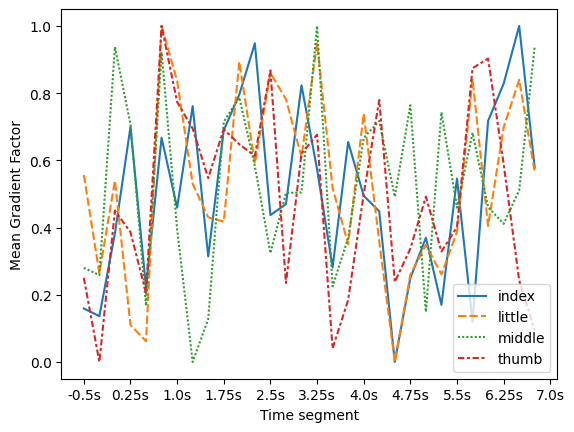

: 

In [12]:

df = pd.DataFrame.from_dict(result, orient='index').T


# Plot using Seaborn
ax = sns.lineplot(data=df)

# Set y-axis tick labels
x_labels = np.arange(-0.5, 7.5, 7.5/10)
x_labels = [f'{str(x)}s' for x in x_labels]
x_ticks = np.linspace(0, 30, num=len(x_labels))

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)




# Set axis labels
ax.set_xlabel('Time segment')
ax.set_ylabel('Mean Gradient Factor')

plt.savefig(f'ring_plots/S{subject_id+1}_DL_time_saliency.png', dpi=1000)